In [217]:
import numpy as np
import pandas as pd
from sklearn.neural_network import BernoulliRBM

import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline

In [197]:
class RBM(object):
    
    def __init__(self, num_hidden=5):
        self.num_hidden = num_hidden        
        
    def initializeParameters(self, D, K):
        """
        D: dimenion of the visible layer
        K: dimension of the hidden layer
        """
        
        # W = np.random.randn(K, D) * 0.01
        # the following initialization will have faster convergence
        W = np.random.uniform(low=-0.1 * np.sqrt(6.0/(D+K)), 
                              high=0.1 * np.sqrt(6.0/(D+K)),
                              size=(K, D))
        hidden_bias = np.zeros((K, 1))
        visible_bias = np.zeros((D, 1))
        
        parameters = {'W': W, 'b': hidden_bias, 'c': visible_bias}
        
        return parameters
        
    
    def _sigmoid(self, Z):
        return 1.0/(1.0+np.exp(-Z))
    
    def fit(self, X, learning_rate=0.1, n_iters=1000):
        """
        X: shape (n_features, n_samples), each column corresponds to one training example
        
        """
    
        D, m = X.shape[0], X.shape[1]
        K = self.num_hidden
        
        parameters = self.initializeParameters(D, K)
        
        costs = []
        A0 = X
        alpha = learning_rate / float(m)
        for i in range(n_iters):
            W = parameters['W']
            hidden_bias = parameters['b']            
            visible_bias = parameters['c']
            
            # positive-CD phase, propagate to hidden layer        
            Z1 = hidden_bias + np.dot(W, A0)
            positive_hidden_probs = self._sigmoid(Z1)
            A1 = (positive_hidden_probs > 0.5).astype(np.float32)
            assert positive_hidden_probs.shape == (K, m)
            
            # propagate back to the visible layer
            Z2 = visible_bias + np.dot(W.T, A1)
            negative_visible_probs = self._sigmoid(Z2)
            A2 = (negative_visible_probs > 0.5).astype(np.float32)
            assert negative_visible_probs.shape == (D, m)
        
            # negative-CD phase, propagate again to the hidden layer
            # Z3 = hidden_bias + np.dot(W, A2) # use solft probabilities instead of actual states
            Z3 = hidden_bias + np.dot(W, negative_visible_probs)
            negative_hidden_probs = self._sigmoid(Z3)
            A3 = (negative_hidden_probs > 0.5).astype(np.float32)
            assert negative_hidden_probs.shape == (K, m)
        
            # compute gradients
            grads = self.computeGradients(positive_hidden_probs, X, negative_hidden_probs, negative_visible_probs)
            
            # update parameters
            parameters = self.updateParameters(parameters, grads, alpha)
            
            # compute cost, free energy and pseudo-likelihood
            free_energy, pseudo_likelihood = self.computeCost(X, parameters)
            costs.append((free_energy, pseudo_likelihood))
            
            
        self.parameters = parameters
        self.costs = pd.DataFrame(costs, columns=['free_energy', 'pseudo_likelihood'])
        self.fitted = True
        
    def computeGradients(self, H, V, H_tild, V_tild):
        positive_associations = np.dot(H, V.T)
        negative_associations = np.dot(H_tild, V_tild.T)
        dW = positive_associations - negative_associations
        db = np.sum(H - H_tild, axis=1, keepdims=True)
        dc = np.sum(V - V_tild, axis=1, keepdims=True)
        grads = {'dW': dW, 'db': db, 'dc': dc}
        return grads
    
    def updateParameters(self, parameters, grads, alpha):
        W = parameters['W'] + alpha * grads['dW']
        b = parameters['b'] + alpha * grads['db']
        c = parameters['c'] + alpha * grads['dc']
        
        parameters = {'W': W, 'b': b, 'c': c}
        return parameters
    
    def computeCost(self, X, parameters):
        W = parameters['W']
        b = parameters['b']
        c = parameters['c']
        free_energy = self.computeFreeEnergy(X, W, b, c)
        pseudo_likelihood = self.computePseudoLikelihood(X, W, b, c)
        return free_energy, pseudo_likelihood
    
    def computeFreeEnergy(self, X, W, b, c):
        F = np.dot(c.T, X)
        F += np.sum(np.log(np.exp(b + np.dot(W, X))), axis=0, keepdims=True)
        F = -np.squeeze(np.sum(F))
        return F  
    
    def computePseudoLikelihood(self, X, W, b, c):
        return None
    
    # getter functions
    def getWeight(self):
        return self.parameters['W'].copy()
    
    def getHiddenBias(self):
        return self.parameters['b'].copy()
    
    def getVisibleBias(self):
        return self.parameters['c'].copy()
    
    def getCost(self):
        return self.costs.copy()
            

In [198]:
rbm = RBM(num_hidden=2)
training_data = np.array([[1,1,1,0,0,0],
                          [1,0,1,0,0,0],
                          [1,1,1,0,0,0],
                          [0,0,1,1,1,0], 
                          [0,0,1,1,0,0],
                          [0,0,1,1,1,0]])
rbm.fit(training_data.T, learning_rate=0.1, n_iters=1000)

In [220]:
print('Weight:')
print(rbm.getWeight())
print('\nHidden layer bias:')
print(rbm.getHiddenBias().ravel())
print('\nVisible layer bias')
print(rbm.getVisibleBias().ravel())

Weight:
[[ 3.92195392  1.75452282  2.56077734 -3.34011299 -3.91517641 -1.85121968]
 [-2.74379503 -4.01260886  2.28306594  2.94824933  1.30356795 -1.84925676]]

Hidden layer bias:
[ 0.77796201  0.47481822]

Visible layer bias
[-0.11736454 -0.58979065  2.86193605 -0.17312139 -0.6204102  -2.96030642]


In [201]:
sk_rbm = BernoulliRBM(n_components=2, learning_rate=0.1, batch_size=training_data.shape[0], n_iter=1000)
sk_rbm.fit(training_data)

BernoulliRBM(batch_size=6, learning_rate=0.1, n_components=2, n_iter=1000,
       random_state=None, verbose=0)

In [213]:
print('scikit-learn result:\n')
print('Weight:')
print(sk_rbm.components_)
print('\nHidden layer bias:')
print(sk_rbm.intercept_hidden_) 
print('\nVisible layer bias')
print(sk_rbm.intercept_visible_)

scikit-learn result:

Weight:
[[ 0.00273349 -0.01816993  1.97808832  0.0105905   0.05174911 -1.58588198]
 [-0.00788665 -0.02980285  2.00393623  0.02539344  0.06107948 -1.6046757 ]]

Hidden layer bias:
[ 0.69386835  0.70504212]

Visible layer bias
[-0.16666667 -0.58333333  2.36666667 -0.23333333 -0.5        -2.73333333]


In [214]:
free_energy = rbm.computeFreeEnergy(training_data.T, rbm.getWeight(), rbm.getHiddenBias(), rbm.getVisibleBias())
sk_free_energy = np.sum(sk_rbm._free_energy(training_data))
print('free energy: {0:.3f}'.format(free_energy))
print('scikit-learn free energy: {0:.3f}'.format(sk_free_energy))

free energy: -43.079
scikit-learn free energy: -44.116


In [215]:
costs = rbm.getCost()['free_energy']

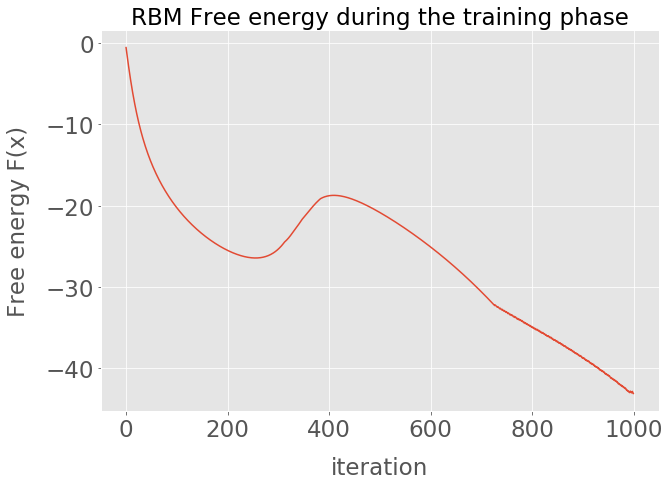

In [227]:
FONTSIZE = 23
fig, ax = plt.subplots(1, figsize=(10, 7))
ax.plot(costs, lw=1.5)  #, markersize=5)
ax.set_xlabel('iteration', fontsize=FONTSIZE, labelpad=15)
ax.set_ylabel('Free energy F(x)', fontsize=FONTSIZE, labelpad=15)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(FONTSIZE)
    tick.label.set_rotation(0)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(FONTSIZE)
    tick.label.set_rotation(0)
ax.set_title('RBM Free energy during the training phase', fontsize=FONTSIZE)